In [134]:
# Imports
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, pacf, acf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, het_arch
from statsmodels.graphics.tsaplots import plot_pacf



### Data Preprocessing
We start by reading the different csv-files that contain the data.

In [135]:
# Define the folder path
data_path = "data/"

# Load datasets
zero_coupon = pd.read_csv(os.path.join(data_path, "zero_coupon_rates.csv"), delimiter=";")
exchange_rates = pd.read_csv(os.path.join(data_path, "usd_nok.csv"), delimiter=";")
inflation = pd.read_csv(os.path.join(data_path, "kpi.csv"), delimiter=";")
osebx = pd.read_csv(os.path.join(data_path, "osebx_prices.csv"), delimiter=";")

# Replace commas with dots in the KPI column and convert to float
inflation["kpi"] = inflation["kpi"].str.replace(",", ".").astype(float)


Then, we check for missing values in the data

In [136]:
datasets = {
    "OSEBX": osebx,
    "Zero Coupon": zero_coupon,
    "Exchange Rates": exchange_rates,
    "Inflation": inflation
}

for name, df in datasets.items():
    print(f"\nMissing Values in {name} Dataset:")
    print(df.isnull().sum())


Missing Values in OSEBX Dataset:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Missing Values in Zero Coupon Dataset:
FREQ           0
Frequency      0
TENOR          0
Tenor          0
DECIMALS       0
TIME_PERIOD    0
OBS_VALUE      0
dtype: int64

Missing Values in Exchange Rates Dataset:
FREQ                    0
Frequency               0
BASE_CUR                0
Base Currency           0
QUOTE_CUR               0
Quote Currency          0
TENOR                   0
Tenor                   0
DECIMALS                0
CALCULATED              0
UNIT_MULT               0
Unit Multiplier         0
COLLECTION              0
Collection Indicator    0
TIME_PERIOD             0
OBS_VALUE               0
dtype: int64

Missing Values in Inflation Dataset:
Date    0
kpi     0
dtype: int64


From the output, we can see that the data does not contain any null values.

Continue with converting the dates to Datetime format. Also, for inflation, since we are originally only having monthly data, we use forward-fill to get daily inflation data.

In [137]:
# Convert Date to Datetime format
osebx["Date"] = pd.to_datetime(osebx["Date"])
zero_coupon["TIME_PERIOD"] = pd.to_datetime(zero_coupon["TIME_PERIOD"])
exchange_rates["TIME_PERIOD"] = pd.to_datetime(exchange_rates["TIME_PERIOD"])
inflation["Date"] = pd.to_datetime(inflation["Date"], format="%YM%m")

# Create a full date range from the first to last available date in your dataset
full_date_range = pd.date_range(start=inflation["Date"].min(), end=inflation["Date"].max(), freq="D")

# Create a DataFrame with daily dates
inflation_daily = pd.DataFrame({"Date": full_date_range})

# Merge with the original inflation data (left join) and forward-fill missing values
inflation_daily = inflation_daily.merge(inflation, on="Date", how="left")
inflation_daily["kpi"] = inflation_daily["kpi"].interpolate(method="linear")

Compute log returns for OSEBX. Also, rename columns to ensure that all dataframes have a column named "Date", so that we can merge all datasets on "Date". After having merged all the datasets to one dataframe, we drop all the columns we are not interested in. Consequently, the columns we are left with are "Date", "kpi", "zero_coupon_rate", "usd_nok_exchange_rate", and "log_return".

In [138]:
# Compute log returns
osebx["log_return"] = np.log(osebx["Close"] / osebx["Close"].shift(1))
osebx.dropna(inplace=True)  # Drop the first row where return cannot be calculated

# Rename columns to "Date"
zero_coupon.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)
exchange_rates.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)

# Merge all datasets on 'Date'
df = inflation_daily.merge(zero_coupon, on="Date", how="inner")
df = df.merge(exchange_rates, on="Date", how="inner")
df = df.merge(osebx, on="Date", how="inner") 

df = df.drop(columns=["Close", "High", "Low", "Open", "Volume",
       "FREQ_x", "Frequency_x", "TENOR_x", "Tenor_x", "DECIMALS_x",
       "FREQ_y", "Frequency_y", "BASE_CUR", "Base Currency",
       "QUOTE_CUR", "Quote Currency", "TENOR_y", "Tenor_y", "DECIMALS_y",
       "CALCULATED", "UNIT_MULT", "Unit Multiplier", "COLLECTION",
       "Collection Indicator"])

df.rename(columns={"OBS_VALUE_x": "zero_coupon_rate"}, inplace=True)
df.rename(columns={"OBS_VALUE_y": "usd_nok_exchange_rate"}, inplace=True)

print(df.head())

        Date        kpi  zero_coupon_rate  usd_nok_exchange_rate  log_return
0 2015-03-03  99.225806             1.540                 7.7091    0.005967
1 2015-03-04  99.238710             1.546                 7.7441   -0.012511
2 2015-03-05  99.251613             1.567                 7.7207    0.011992
3 2015-03-06  99.264516             1.639                 7.7917    0.002769
4 2015-03-09  99.303226             1.676                 7.8992   -0.006572


Check for multicollinearity by computing the correlation matrix.

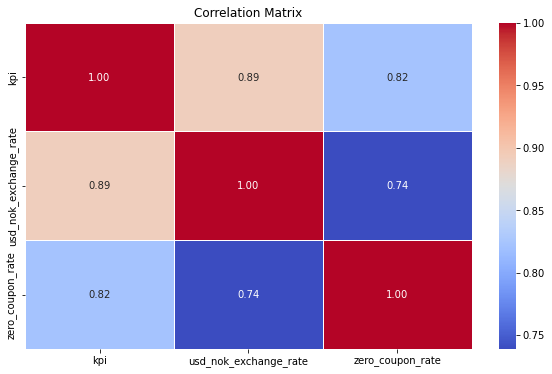

In [139]:
# Compute the correlation matrix
selected_columns = ["kpi", "usd_nok_exchange_rate", "zero_coupon_rate"]
corr_matrix = df[selected_columns].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

We define highly correlated values to have a correlation coefficient >0.9. Because all variables have a correlation coefficient below 0.9, we decide to keep all of the explanatory variables. However, we notice that especially between usd_nok_exchange_rate and kpi and between zero_coupon_rate and kpi the correlation coefficient is close to the boundary. 

After having checked for correlation, we check for stationarity by applying the Augmented Dickey-Fuller (ADF) test.

In [140]:
# Check for stationarity 
def adf_test(series, var_name):
    result = adfuller(series.dropna())  
    print("="*40)  # Separator line
    print(f"ADF Test for {var_name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else "Non-stationary")
    print("="*40 + "\n")  # End separator

# Run ADF tests on all relevant variables
adf_test(df["log_return"], "Log Return")
adf_test(df["zero_coupon_rate"], "Zero Coupon Rate")  
adf_test(df["usd_nok_exchange_rate"], "USD/NOK Exchange Rate")  
adf_test(df["kpi"], "CPI")

ADF Test for Log Return:
ADF Statistic: -15.8678
p-value: 0.0000
Stationary

ADF Test for Zero Coupon Rate:
ADF Statistic: -0.5795
p-value: 0.8755
Non-stationary

ADF Test for USD/NOK Exchange Rate:
ADF Statistic: -1.4185
p-value: 0.5734
Non-stationary

ADF Test for CPI:
ADF Statistic: 1.7132
p-value: 0.9982
Non-stationary



From the output, we can see that the variables "zero coupon rate", "USD/NOK exchange rate", and "CPI" are non-stationary. To get these variables to be stationary, we apply first differences to these columns.

In [141]:
# Transform to stationary variables by applying first differences
df["d_kpi"] = df["kpi"].diff()
df["d_zero_coupon_rate"] = df["zero_coupon_rate"].diff()
df["d_usd_nok_exchange_rate"] = df["usd_nok_exchange_rate"].diff()

df = df.dropna()

adf_test(df["d_zero_coupon_rate"], "Differenced Zero Coupon Rate") 
adf_test(df["d_usd_nok_exchange_rate"], "Differenced USD/NOK Exchange Rate") 
adf_test(df["d_kpi"], "Differenced CPI") 

ADF Test for Differenced Zero Coupon Rate:
ADF Statistic: -45.8067
p-value: 0.0000
Stationary

ADF Test for Differenced USD/NOK Exchange Rate:
ADF Statistic: -50.8674
p-value: 0.0000
Stationary

ADF Test for Differenced CPI:
ADF Statistic: -6.7596
p-value: 0.0000
Stationary



From the output, we can see that all the variables now are stationary.

In [142]:
print(df.head())

        Date        kpi  zero_coupon_rate  usd_nok_exchange_rate  log_return  \
1 2015-03-04  99.238710             1.546                 7.7441   -0.012511   
2 2015-03-05  99.251613             1.567                 7.7207    0.011992   
3 2015-03-06  99.264516             1.639                 7.7917    0.002769   
4 2015-03-09  99.303226             1.676                 7.8992   -0.006572   
5 2015-03-10  99.316129             1.748                 8.0457   -0.017672   

      d_kpi  d_zero_coupon_rate  d_usd_nok_exchange_rate  
1  0.012903               0.006                   0.0350  
2  0.012903               0.021                  -0.0234  
3  0.012903               0.072                   0.0710  
4  0.038710               0.037                   0.1075  
5  0.012903               0.072                   0.1465  


#### Split into training and testing data

In [143]:
# Define the split percentage (e.g., 80% train, 20% test)
split_idx = int(len(df) * 0.8)

# Split the data
train_df = df.iloc[:split_idx].copy()  # First 80% for training
test_df = df.iloc[split_idx:].copy()   # Last 20% for testing

# Define training and testing sets
X_train, y_train = train_df[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']], train_df['log_return']
X_test, y_test = test_df[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']], test_df['log_return']


### Multiple Linear Regression (MLR)

In [144]:
# Add constant for intercept
X_train_ols = sm.add_constant(X_train)

# Train OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Print summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     78.97
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           3.03e-48
Time:                        11:26:25   Log-Likelihood:                 6183.9
No. Observations:                1979   AIC:                        -1.236e+04
Df Residuals:                    1975   BIC:                        -1.234e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Checking for autocorrelation using Breusch-Godfrey test

In [145]:
def breusch_godfrey_test(model, nlags=1):
   
    # Perform the test
    lm_stat, p_value, f_stat, f_p_value = acorr_breusch_godfrey(model, nlags=nlags)

    # Print results
    print(f"Breusch-Godfrey Test (nlags={nlags})")
    print(f"LM Statistic: {lm_stat:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print(f"F-Statistic: {f_stat:.4f}")
    print(f"F-Test P-Value: {f_p_value:.4f}")

    # Interpretation
    if p_value < 0.05:
        print("Autocorrelation detected in residuals (reject H0).")
    else:
        print("No significant autocorrelation detected (fail to reject H0).")

    # Return results as a dictionary
    return {
        "LM Statistic": lm_stat,
        "P-Value": p_value,
        "F-Statistic": f_stat,
        "F-Test P-Value": f_p_value
    }

results = breusch_godfrey_test(ols_model, nlags=1)

Breusch-Godfrey Test (nlags=1)
LM Statistic: 7.5384
P-Value: 0.0060
F-Statistic: 7.5481
F-Test P-Value: 0.0061
Autocorrelation detected in residuals (reject H0).


To deal with autocorrelation we will try to add lagged variables. To get an impression of how many lags to use we visualize the partial autocorrelation function (PACF). 

<Figure size 576x360 with 0 Axes>

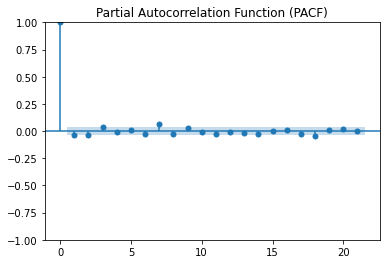

In [146]:
# Check PACF for 'log_return'
plt.figure(figsize=(8, 5))
plot_pacf(df['log_return'], lags=21, method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

#### PACF

The figure above shows the partial autocorrelation coefficient for each lag, with the blue dashed lines representing the 95% confidence interval. Any bar extending this interval indicates statistical significance. From the figure, we observe that lag 7 and lag 18 seems to be most significant. 

We try to add lagged variables for lag 7 and lag 18 to remove autocorrelation.

In [147]:
"""
train_df['d_kpi_lag7'] = train_df['d_kpi'].shift(7)
train_df['d_zero_coupon_rate_lag7'] = train_df['d_zero_coupon_rate'].shift(7)
train_df['d_usd_nok_exchange_rate_lag7'] = train_df['d_usd_nok_exchange_rate'].shift(7)

train_df['d_kpi_lag18'] = train_df['d_kpi'].shift(18)
train_df['d_zero_coupon_rate_lag18'] = train_df['d_zero_coupon_rate'].shift(18)
train_df['d_usd_nok_exchange_rate_lag18'] = train_df['d_usd_nok_exchange_rate'].shift(18)

# Due to lagging NaN values are dropped in the training set 
train_df.dropna(inplace=True)

# Define the new independent variables
X = train_df[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate',
        'd_kpi_lag7', 'd_zero_coupon_rate_lag7', 'd_usd_nok_exchange_rate_lag7', 
        'd_kpi_lag18','d_zero_coupon_rate_lag18', 'd_usd_nok_exchange_rate_lag18']]

y_train = train_df['log_return']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit the new OLS model
model1 = sm.OLS(y_train, X).fit()
"""

"\ntrain_df['d_kpi_lag7'] = train_df['d_kpi'].shift(7)\ntrain_df['d_zero_coupon_rate_lag7'] = train_df['d_zero_coupon_rate'].shift(7)\ntrain_df['d_usd_nok_exchange_rate_lag7'] = train_df['d_usd_nok_exchange_rate'].shift(7)\n\ntrain_df['d_kpi_lag18'] = train_df['d_kpi'].shift(18)\ntrain_df['d_zero_coupon_rate_lag18'] = train_df['d_zero_coupon_rate'].shift(18)\ntrain_df['d_usd_nok_exchange_rate_lag18'] = train_df['d_usd_nok_exchange_rate'].shift(18)\n\n# Due to lagging NaN values are dropped in the training set \ntrain_df.dropna(inplace=True)\n\n# Define the new independent variables\nX = train_df[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate',\n        'd_kpi_lag7', 'd_zero_coupon_rate_lag7', 'd_usd_nok_exchange_rate_lag7', \n        'd_kpi_lag18','d_zero_coupon_rate_lag18', 'd_usd_nok_exchange_rate_lag18']]\n\ny_train = train_df['log_return']\n\n# Add a constant for intercept\nX = sm.add_constant(X)\n\n# Fit the new OLS model\nmodel1 = sm.OLS(y_train, X).fit()\n"

In [148]:
#results1 = breusch_godfrey_test(model1, nlags=1)
#print(results1)

Add lags until no autocorrelation

In [149]:
# Define the lags you want to create
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
variables = ['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']

# Create lagged variables using a loop
for var in variables:
    for lag in lags:
        train_df[f'{var}_lag{lag}'] = train_df[var].shift(lag)

# Drop NaN values introduced by lagging
train_df.dropna(inplace=True)

# Define independent variables dynamically
X = train_df[[col for col in train_df.columns if col.startswith('d_kpi') or 
               col.startswith('d_zero_coupon_rate') or 
               col.startswith('d_usd_nok_exchange_rate')]]


y_train = train_df['log_return']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit the new OLS model
model2 = sm.OLS(y_train, X).fit()


Check for autocorrelation again

In [150]:
results2 = breusch_godfrey_test(model2, nlags=1)


Breusch-Godfrey Test (nlags=1)
LM Statistic: 3.7038
P-Value: 0.0543
F-Statistic: 3.6215
F-Test P-Value: 0.0572
No significant autocorrelation detected (fail to reject H0).


We continue with using model with only lags 7 and 18. Bla bla

In [151]:
# Define the lags we want to keep
keep_lags = [7, 18]

# Keep only the original variables and the selected lagged variables
columns_to_keep = ['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']  # Original columns
columns_to_keep += [f'{var}_lag{lag}' for var in variables for lag in keep_lags]  # Only lags 7 & 18

# Select only the necessary columns
train_df = train_df[columns_to_keep + ['log_return']]

# Drop NaN values introduced by lagging
train_df.dropna(inplace=True)

# Define independent and dependent variables
X = train_df.drop(columns=['log_return'])
y_train = train_df['log_return']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit the new OLS model
model3 = sm.OLS(y_train, X).fit()

results3 = breusch_godfrey_test(model3, nlags=1)


Breusch-Godfrey Test (nlags=1)
LM Statistic: 6.2129
P-Value: 0.0127
F-Statistic: 6.1976
F-Test P-Value: 0.0129
Autocorrelation detected in residuals (reject H0).


#### Heteroscedasticity
We test for heteroscedasticity using the ARCH test, as it is well-suited for time-series data.

In [152]:
# Extract residuals
residuals = model3.resid

# Perform ARCH test
arch_test = het_arch(residuals)

# Print results
print(f"ARCH Test Statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")

ARCH Test Statistic: 393.03892575241923
p-value: 2.8508690368873136e-78


To deal with heteroscedasticity we use heteroscedasticity-consistent standard error estimates.
HC3 is conservative and recommended for larger sample sizes. Since our sample size is approximately 2000 observations it can be considered medium to large, and HC3 could be a good choice. 


In [153]:
# Compute robust standard errors (Huber-White/HC3 for larger samples)
model_robust = model3.get_robustcov_results(cov_type='HC3')

# Print summary with robust standard errors
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     6.497
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           3.70e-09
Time:                        11:26:25   Log-Likelihood:                 6098.5
No. Observations:                1949   AIC:                        -1.218e+04
Df Residuals:                    1939   BIC:                        -1.212e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

#### Model Evaluation

### ARIMAX

In [154]:
# TODO: Elias og Erik